In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import svds
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import random
random.seed(23456)
np.random.seed(23456)

## Read Data

In [4]:
books = pd.read_csv("book_data_v3.csv")
book_revs = pd.read_csv("reviews_v6.csv")

In [5]:
books.head()

,ISBN.10,ISBN.13,Language,author,image_url,name,review_url,url
0,1911015486,978-1911015482,english,Piggyback,https://images-na.ssl-images-amazon.com/images...,The Legend of Zelda: Breath of the Wild The Co...,https://www.amazon.com/Legend-Zelda-Complete-O...,https://www.amazon.com/Legend-Zelda-Complete-O...
1,078696619X,978-0786966196,english,Wizards RPG Team,https://images-na.ssl-images-amazon.com/images...,Dungeon Master's Screen Reincarnated,https://www.amazon.com/Dungeon-Masters-Screen-...,https://www.amazon.com/Dungeon-Masters-Screen-...
2,62433970,978-0062433978,english,Christopher Moore,https://images-na.ssl-images-amazon.com/images...,Noir: A Novel,https://www.amazon.com/Noir-Novel-Christopher-...,https://www.amazon.com/Noir-Novel-Christopher-...
3,345535529,978-0345535528,english,George R. R. Martin,https://images-na.ssl-images-amazon.com/images...,A Game of Thrones / A Clash of Kings / A Storm...,https://www.amazon.com/Thrones-Clash-Kings-Swo...,https://www.amazon.com/Thrones-Clash-Kings-Swo...
4,525622136,978-0525622130,english,Daniel José Older,https://images-na.ssl-images-amazon.com/images...,Last Shot (Star Wars): A Han and Lando Novel,https://www.amazon.com/Last-Shot-Star-Wars-Lan...,https://www.amazon.com/Last-Shot-Star-Wars-Lan...


In [6]:
book_revs.head()

,rating,user_link,user_name,book_id
0,5,/gp/profile/amzn1.account.AHVQ2I7NIIICSGLMITUH...,Laurel,316769495
1,5,/gp/profile/amzn1.account.AFLBOK7ROK6O36BXI2XX...,Thomas Truthsayer,316769495
2,4,/gp/profile/amzn1.account.AFVFVS25QJVCFIMPGL44...,Amazon Customer,316769495
3,5,/gp/profile/amzn1.account.AGECMZA77X4ECMFL4L6Z...,Starlifter,316769495
4,5,/gp/profile/amzn1.account.AE5DLBCV4FX72KSZDOFE...,Mr.Punch,316769495


## Processing Data

In [7]:
book_revs = book_revs.dropna(how ='any')

### Generating user ids

In [8]:
user_links = set(book_revs['user_link'])
userId_map = dict(zip(user_links, range(len(user_links))))
book_revs['user_id'] = book_revs['user_link'].apply(lambda x: userId_map.get(x))
book_revs.head()

,rating,user_link,user_name,book_id,user_id
0,5,/gp/profile/amzn1.account.AHVQ2I7NIIICSGLMITUH...,Laurel,316769495,45046
1,5,/gp/profile/amzn1.account.AFLBOK7ROK6O36BXI2XX...,Thomas Truthsayer,316769495,24958
2,4,/gp/profile/amzn1.account.AFVFVS25QJVCFIMPGL44...,Amazon Customer,316769495,21485
3,5,/gp/profile/amzn1.account.AGECMZA77X4ECMFL4L6Z...,Starlifter,316769495,152054
4,5,/gp/profile/amzn1.account.AE5DLBCV4FX72KSZDOFE...,Mr.Punch,316769495,138369


In [9]:
import math
def process(ratings, books, P):
    """ Given a dataframe of ratings and a random permutation, split the data into a training 
        and a testing set, in matrix form. 
        
        Args: 
            ratings (dataframe) : dataframe of MovieLens ratings
            movies (dataframe) : dataframe of MovieLens movies
            P (numpy 1D array) : random permutation vector
            
        Returns: 
            (X_tr, X_te, movie_names)  : training and testing splits of the ratings matrix (both 
                                         numpy 2D arrays), and a python list of movie names 
                                         corresponding to the columns of the ratings matrices. 
    """
    
    bookID = ratings['book_id'].unique()
    userID = ratings['user_id'].unique()
    bks = books.set_index(['ISBN.10'])
    
    bk_names = list(bks.loc[bookID]['name'])
    bk_id = list(bks.loc[bookID].index)
    bk_dict = {mi:i for i,mi in enumerate(bookID)}
    
    X_tr = np.zeros((len(userID),len(bookID)))
    X_val = np.zeros((len(userID),len(bookID)))
    X_te = np.zeros((len(userID),len(bookID)))
    X_full_tr = np.zeros((len(userID),len(bookID)))
    
    tr_size = math.floor(float(7*len(P))/10.0)
    val_size = math.floor(float(2*len(P))/10.0)
    tr_data = ratings.iloc[P[0:tr_size]]
    val_data = ratings.iloc[P[tr_size:tr_size+val_size]]
    te_data = ratings.iloc[P[tr_size+val_size:]]
    full_tr_data = ratings.iloc[P[:tr_size+val_size]]
    
    for index, row in tr_data.iterrows():
        X_tr[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']
        
    for index, row in val_data.iterrows():
        X_val[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']
        
    for index, row in te_data.iterrows():
        X_te[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']
    
    for index, row in full_tr_data.iterrows():
        X_full_tr[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']

    return X_tr, X_val, X_te, X_full_tr, bk_names, bk_id

  

# AUTOLAB_IGNORE_START
X_tr, X_val, X_te, X_full_tr, bNames, bIds = process(book_revs, books, np.random.permutation(len(book_revs)))
print(X_tr.shape, X_val.shape, X_te.shape, X_full_tr.shape, bNames[:5], bIds[:5])
# AUTOLAB_IGNORE_STOP

(181240, 236) (181240, 236) (181240, 236) (181240, 236) ['Franny and Zooey', 'A Wild Sheep Chase: A Novel', 'Dragons of Autumn Twilight (Dragonlance Chronicles, Volume I)', 'The Chosen: A Novel of the Black Dagger Brotherhood', 'Battlefront II: Inferno Squad (Star Wars)'] ['316769495', '037571894X', '786915749', '451475208', '1524796824']


In [10]:
book_ID = book_revs['book_id'].unique()
user_ID = book_revs['user_id'].unique()
print(len(book_ID))
print(len(user_ID))

236
181240


## Error Calculation

In [11]:
def error(X, X_hat):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each movie
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    W = np.zeros(X.shape)
    mask = X!=0
    W[mask] = 1
    err = np.square(X-X_hat*W)
    return np.mean(err)

### SVD

In [12]:
err_svd =[]
for k in range(1,100):
    u, s, vt = svds(X_tr, k = k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    err_svd.append({'k': k, 'Error': error(X_val, X_pred)})

In [13]:
# print(error(X_tr, X_pred), error(X_te, X_pred))
error_svd = pd.DataFrame(err_svd)
error_svd

,Error,k
0,0.019517,1
1,0.019505,2
2,0.019495,3
3,0.019491,4
4,0.019491,5
5,0.019488,6
6,0.019490,7
7,0.019506,8
8,0.019503,9
9,0.019508,10


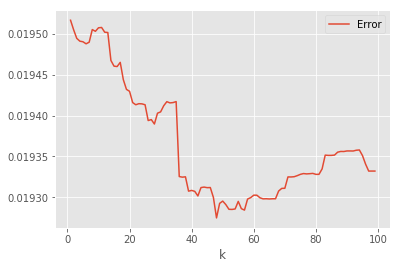

In [14]:
error_svd.plot(x='k', y='Error')

In [36]:
opimal_k = 50
u, s, vt = svds(X_full_tr, k = opimal_k)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print(error(X_full_tr, X_pred), error(X_te, X_pred))
print(u.shape, s.shape, vt.shape)

0.02148088820427216 0.009597420895097132
(181240, 50) (50,) (50, 236)


### Matrix Factorization implementation

In [16]:
def train(X, X_te, k, U, V, niters=51, lam=10, verbose=False):
    """ Train a collaborative filtering model. 
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each movie
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages
            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    """
    W = np.zeros(X.shape)
    mask = X!=0
    mask2 = mask.T
    xtrans = X.T
    
    for i in range(niters):
        for m in range(U.shape[0]):
            v = V[mask[m]]
#             print('v ',v)
            r = X[m][mask[m]]
#             print('r ', r)
            um = np.linalg.solve(v.T @ v + lam*np.identity(v.shape[1]), v.T @ r)
#             print('um ', um)
            U[m] = um
#         print(U)
            
        for n in range(V.shape[0]):
            u = U[mask2[n]]
#             print('u ',u)
            r2 = xtrans[n][mask2[n]]
#             print('r2 ', r2)
            vn = np.linalg.solve(u.T @ u + lam*np.identity(u.shape[1]), u.T @ r2)
#             print('vn ', vn)
            V[n] = vn
#         print(V)
#         print('-------------------------------------------------')
        if(verbose and i%5==0):
            X_pred = (U@V.T)
            print(i,error(X, X_pred),error(X_te, X_pred))
    return U,V


In [23]:
# book_ID = book_revs['book_id'].unique()
# user_ID = book_revs['user_id'].unique()

# err_mf = []
for k in range(250,300, 10):
    U0 = np.random.random((len(user_ID),k))
    V0 = np.random.random((len(book_ID),k))
    U1,V1 = train(X_tr, X_te, k, U0, V0, niters=10, lam=10, verbose=True)
    X_pred = (U1@V1.T)
    err_mf.append({'k': k, 'Error': error(X_val, X_pred)})

0 0.000758837641759706 0.008474973594486727
5 0.0005080556129367174 0.008529972193688392
0 0.0007904817222825817 0.00847309213321983
5 0.0005103453537928461 0.008522624448315684
0 0.0008094807892339205 0.00847296480677095
5 0.0005116354344068027 0.008520083008225699
0 0.0008494508095634451 0.008475478881839894
5 0.0005143736528925102 0.008520237783839812
0 0.000873219364065763 0.00847488149853406
5 0.0005162431787215613 0.008514058890552786


In [24]:
error_mf = pd.DataFrame(err_mf)
error_mf

,Error,k
0,0.017782,10
1,0.017699,20
2,0.017609,30
3,0.017561,40
4,0.017505,50
5,0.017448,60
6,0.017383,70
7,0.017345,80
8,0.017306,90
9,0.017284,100


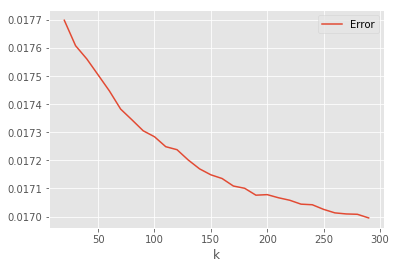

In [25]:
error_mf[1:].plot(x='k', y='Error')

In [26]:
opimal_k = 300

U0 = np.random.random((len(user_ID),opimal_k))
V0 = np.random.random((len(book_ID),opimal_k))
U1,V1 = train(X_full_tr, X_te, opimal_k, U0, V0, niters=100, lam=10, verbose=True)
X_pred = (U1@V1.T)
print(error(X_full_tr, X_pred), error(X_te, X_pred))

0 0.0008580385028962492 0.00822259886261269
5 0.0005132650076030731 0.008282784965272669
10 0.0005232122846869764 0.008303645119015511
15 0.0005296582528888773 0.008304298058770657
20 0.0005328931303198129 0.008299980543013969
25 0.0005346028624936211 0.008295732841025343
30 0.0005355691021515414 0.008292152731738096
35 0.0005361392515414261 0.008288975254291203
40 0.0005364868292796151 0.008286076182265059
45 0.0005367042587762982 0.008283429284517013
50 0.0005368428031621753 0.00828103051811132
55 0.0005369320824099638 0.008278874449872908
60 0.0005369898809394394 0.008276950026718596
65 0.0005370272312382462 0.008275241571471307
70 0.0005370511578503726 0.008273730717415658
75 0.0005370662233152479 0.008272398095880113
80 0.0005370754347040223 0.008271224540483542
85 0.0005370807940676056 0.00827019185050381
90 0.0005370836426045297 0.008269283218949786
95 0.0005370848811277292 0.008268483426921878
0.0005370851262784862 0.008267912771826745


## Providing an recommendation

In [27]:
def recommend(X, U, V, bNames):
    """ Recommend a new movie for every user.
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            U (numpy 2D array) : a learned matrix of features for each user
            V (numpy 2D array) : a learned matrix of features for each movie
            movieNames : a list of movie names corresponding to the columns of the ratings matrix
        Returns
            (list) : a list of movie names recommended for each user
    """
    mask = X!=0
    X_hat = (U@V.T)
    X_hat[mask] = -1
    rec_list = np.argmax(X_hat,axis=1)
    mov = [bNames[i] for i in rec_list]
    return mov
        
 
    
# AUTOLAB_IGNORE_START
recommendations = recommend(X_tr, U1, V1, bIds)
print(recommendations[:5])
# AUTOLAB_IGNORE_STOP

['345538374', '345535529', '345538374', '451524934', '345535529']


In [28]:
import urllib

def present_recommendation(recommended_id, book_data):
    book_info = book_data.loc[recommended_id]
    image_url = book_info['image_url']
    
    f = urllib.request.urlopen(image_url)
    print('Book Name:', book_info['name'])
    print('By-', book_info['author'])
    a = plt.imread(f, 0)
    plt.imshow(a)
    plt.grid(False)
    plt.axis('off')

    plt.show()

Book Name: 1984 (Signet Classics)
By- George Orwell


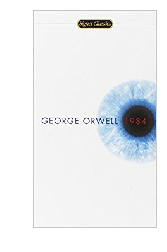

In [32]:
present_recommendation(recommendations[3], books.set_index(['ISBN.10']))

In [35]:
error_mf.to_csv('mf.csv', index = False)
error_svd.to_csv('svd.csv', index = False)